<a href="https://colab.research.google.com/github/stp511/HealthPredictionProject2/blob/main/Draft4_StevenPhillips_Project2_Part4_StrokePredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 2 Part 4 - Stroke Predictions**
- **Steven Phillips**
- November 28, 2022

The goal of this project will be to use the data set and create a best model for predicting the presence of stroke in patients.  

## **Import Libraries, Load, Copy and Explore Data**


In [175]:
#import seaborn, matplotlib and the pandas and numpy library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering, pipelines, and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.decomposition import PCA

# metrics
from sklearn.metrics import  precision_score, recall_score, accuracy_score, f1_score, \
       confusion_matrix, ConfusionMatrixDisplay, classification_report

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
#mount data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load the data for Stroke Prediction Data Set csv file as a data frame, copy the data frame and present the first five rows
filename = '/content/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(filename)
df_ml = df.copy()
df_ml.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## **Project 2 - Part 1 Questions**

1. Source of Data
2. Brief description of data
3. What is the target?
4. What does one row represent?
5. Is this a regression or classification problem?
6. How many features does the data have?
7. How many rows in the data set?
8. What, if any, challenges do you foresee in cleaning, exploring, or modeling with this dataset?

### **1. Source of data**

1. The source of this data is the Kaggle website and here is the link:

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

### **2. Brief description of data**

"This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient." 

Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

### **3. What is the target?**

The target for this data set will be the 'stroke' feature.  Specifically, whether or not each patient had a stroke.

### **4. What does one row represent?**

Each row represents a patient from the study.

### **5. Is this a regression or a classification problem?**

The model will predict the stroke feature, which is a binary classification problem, 'stroke' or 'no stroke'.

### **6. How many features does the data have?**

The data comes with 12 features, as seen in the first five rows of the data frame above.  However, the first feature, essentially the patient id, will not be used in modeling.  So there will be 10 features, including a mix of categorical and numerical, to choose from and one target feature.

### **7. How many rows in the data set?**

There are 5,110 observations or rows.

In [4]:
# shape of the data  (rows, columns)
df_ml.shape

(5110, 12)

### **8. What, if any, challenges do you foresee in cleaning, exploring, or modeling with this dataset?**

There are a few issues that present challenges.  Choosing the best classification model will be a challenge.  Initially, cleaning the data set will have issues including dealing with missing entries from the bmi feature and checking the naming is consistent for the object data type features.

In [5]:
# missing data by feature
df_ml.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## **Project 2 - Part 2 Clean and Explore the Data Set**

## **Data Cleaning**

**Be sure to address:**
- delete unnecessary columns
- delete duplicate rows
- identify and address missing values
- identify and correct inconsistencies in data for categorical values


In [6]:
# check number of unique values by feature
df_ml.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

### **'id' unnecessary for analysis and will be dropped here:**

In [7]:
# drop 'id' feature
df_ml = df_ml.drop(columns = ['id'])


### **No duplicated rows to address:**

In [8]:
# check for duplicate rows
df_ml.duplicated().sum()

0

### **Check for missing values:**

In [9]:
df_ml.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### **'bmi' missing 201 values:**

Impute the mean bmi into the 201 missing values.
**Imputing will occur later during preprocessing.**

In [10]:
# calculate the mean 'bmi' and impute into the missing values
# mean_bmi = df_ml['bmi'].mean()
# df_ml['bmi'].fillna(mean_bmi, inplace=True)
# df_ml.isna().sum()

In [11]:
# df_ml.info()

In [12]:
# Check categories for inconsistencies

for col in df_ml.select_dtypes('object'):
  print(f'{df_ml[col].value_counts()} \n')

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64 

Yes    3353
No     1757
Name: ever_married, dtype: int64 

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64 

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64 

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64 



In [13]:
# drop the single row containing 'gender' value = 'Other' 
df_ml = df_ml[df_ml.gender != 'Other']

In [14]:
# df_ml.info()

## **Exploratory Visuals**

- produce univariate visuals for the target and all features
- identify outliers

### **'stroke'**

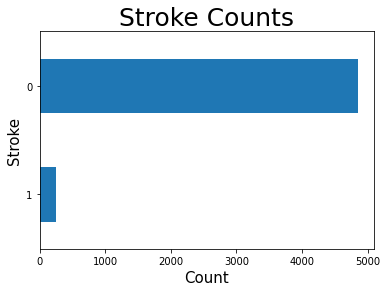

In [15]:
#create a 'stroke' counts bar graph
stroke_counts = df_ml['stroke'].value_counts().sort_values()

# Plot the counts of each stroke level

stroke_counts.plot(kind = 'barh')
plt.title('Stroke Counts', fontsize = 25)
plt.ylabel('Stroke', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'gender'**

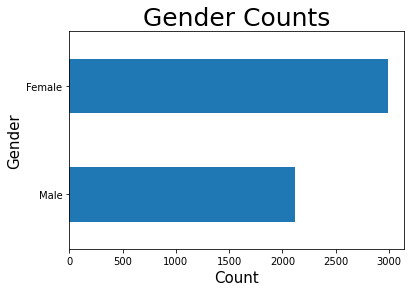

In [16]:
#create a 'gender' counts bar graph
gender_counts = df_ml['gender'].value_counts().sort_values()

# Plot the counts of each gender level

gender_counts.plot(kind = 'barh')
plt.title('Gender Counts', fontsize = 25)
plt.ylabel('Gender', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'ever-married'**

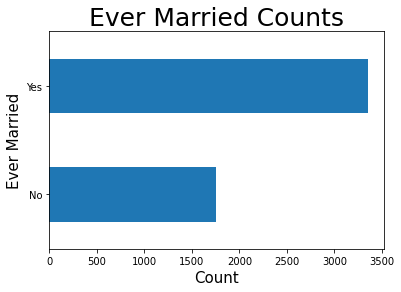

In [17]:
#create a 'ever_married' counts bar graph
marriage_counts = df_ml['ever_married'].value_counts().sort_values()

# Plot the counts of each marriage level

marriage_counts.plot(kind = 'barh')
plt.title('Ever Married Counts', fontsize = 25)
plt.ylabel('Ever Married', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'work_type'**

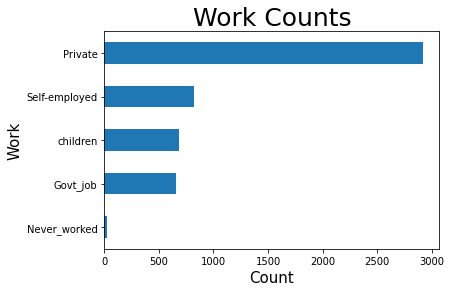

In [18]:
#create a 'work_type' counts bar graph
work_counts = df_ml['work_type'].value_counts().sort_values()

# Plot the counts of each work type level

work_counts.plot(kind = 'barh')
plt.title('Work Counts', fontsize = 25)
plt.ylabel('Work', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'Residence_type'**

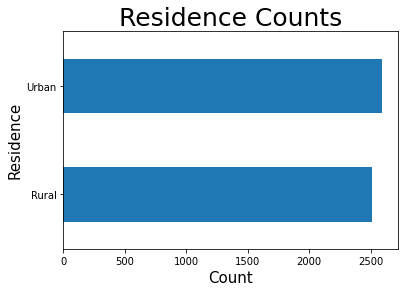

In [19]:
#create a 'residence_type' counts bar graph
residence_counts = df_ml['Residence_type'].value_counts().sort_values()

# Plot the counts of each residence type level

residence_counts.plot(kind = 'barh')
plt.title('Residence Counts', fontsize = 25)
plt.ylabel('Residence', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'smoking_status'**

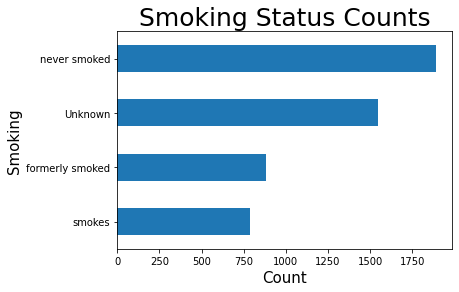

In [20]:
#create a 'smoking_status' counts bar graph
smoking_counts = df_ml['smoking_status'].value_counts().sort_values()

# Plot the counts of each smoking status level

smoking_counts.plot(kind = 'barh')
plt.title('Smoking Status Counts', fontsize = 25)
plt.ylabel('Smoking', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'heart_disease'**

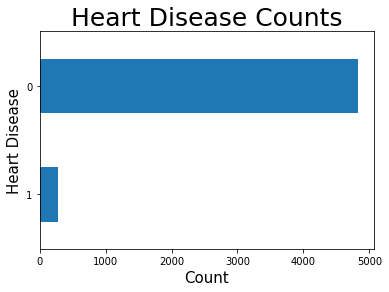

In [21]:
#create a 'heart_disease' counts bar graph
heartdisease_counts = df_ml['heart_disease'].value_counts().sort_values()

# Plot the counts of each heart disease level

heartdisease_counts.plot(kind = 'barh')
plt.title('Heart Disease Counts', fontsize = 25)
plt.ylabel('Heart Disease', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'hypertension'**

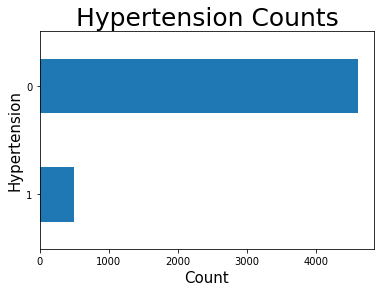

In [22]:
#create a 'hypertension' counts bar graph
hypertension_counts = df_ml['hypertension'].value_counts().sort_values()

# Plot the counts of each heart disease level

hypertension_counts.plot(kind = 'barh')
plt.title('Hypertension Counts', fontsize = 25)
plt.ylabel('Hypertension', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'age'**

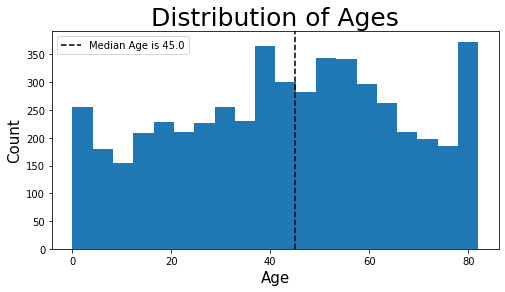

In [23]:
## histogram of ages
plt.figure(figsize = (8,4))
plt.hist(df_ml['age'], bins = 'auto')

## including the median Age
median_age = df_ml['age'].median().round(2)

## titling and labeling
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of Ages', fontsize = 25)

plt.axvline(median_age, color = 'black', linestyle = '--', label = f'Median Age is {median_age}')
plt.legend();

The histogram above is displaying the distribution of the 'age' variable.  The distribution is somewhate uniform with a few small peaks in values, and with ages ranging from very young (close to newborns) all the way to individuals just over 80, and with a median age of 45.

### **'bmi'**

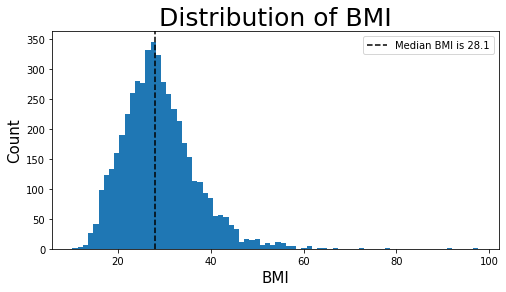

In [24]:
## histogram of bmi
plt.figure(figsize = (8,4))
plt.hist(df_ml['bmi'], bins = 'auto')

## including the median Age
median_bmi = df_ml['bmi'].median().round(2)

## titling and labeling
plt.xlabel('BMI', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of BMI', fontsize = 25)

plt.axvline(median_bmi, color = 'black', linestyle = '--', label = f'Median BMI is {median_bmi}')
plt.legend();

The histogram above is displaying the distribution of the 'bmi' variable.  The distribution is fairly symmetric except for several larger outliers.

### **'avg_glucose_level'**

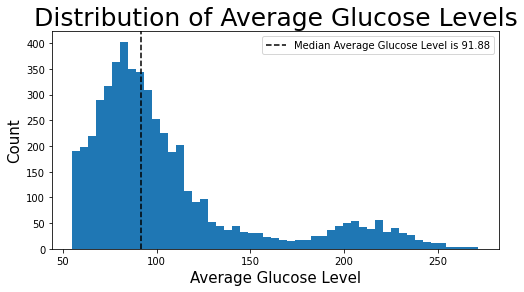

In [25]:
## histogram of Average Glucose Level
plt.figure(figsize = (8,4))
plt.hist(df_ml['avg_glucose_level'], bins = 'auto')

## including the median Age
median_agl = df_ml['avg_glucose_level'].median().round(2)

## titling and labeling
plt.xlabel('Average Glucose Level', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of Average Glucose Levels', fontsize = 25)

plt.axvline(median_agl, color = 'black', linestyle = '--', label = f'Median Average Glucose Level is {median_agl}')
plt.legend();

The histogram above is displaying the distribution of the 'avg_glucose_level' variable.  The distribution is not symmetric, and has some skewness to the right.  The median is below 100 and the maximum value is above 250.

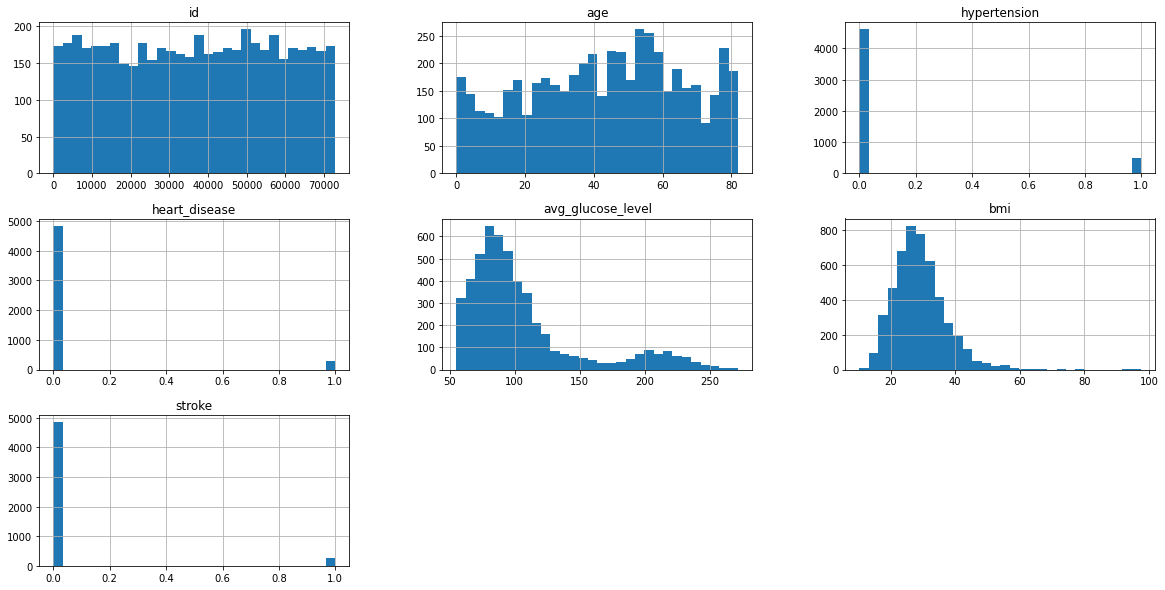

In [26]:
df.hist(bins=30, figsize=(20,10));

### **Check for outliers in 'avg-glucose_level', 'bmi', and 'ages'**

#### **.describe() for initial investigation**

In [27]:
# common summary statistics
df_ml.describe(include = 'all').round(4)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5109,5109.0000,5109.0000,5109.0000,5109,5109,5109,5109.0000,4908.0000,5109,5109.0000
unique,2,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,2994,NaN,NaN,NaN,3353,2924,2596,NaN,NaN,1892,NaN
mean,NaN,43.2300,0.0975,0.0540,NaN,NaN,NaN,106.1404,28.8946,NaN,0.0487
std,NaN,22.6136,0.2966,0.2261,NaN,NaN,NaN,45.2850,7.8543,NaN,0.2153
min,NaN,0.0800,0.0000,0.0000,NaN,NaN,NaN,55.1200,10.3000,NaN,0.0000
25%,NaN,25.0000,0.0000,0.0000,NaN,NaN,NaN,77.2400,23.5000,NaN,0.0000
50%,NaN,45.0000,0.0000,0.0000,NaN,NaN,NaN,91.8800,28.1000,NaN,0.0000
75%,NaN,61.0000,0.0000,0.0000,NaN,NaN,NaN,114.0900,33.1000,NaN,0.0000


### **Boxplots showing the outliers in the numerical columns:**

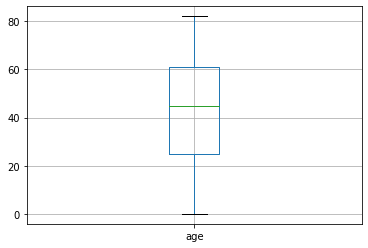

In [28]:
df_ml.boxplot(column = 'age');

No outliers in the 'Age' column.

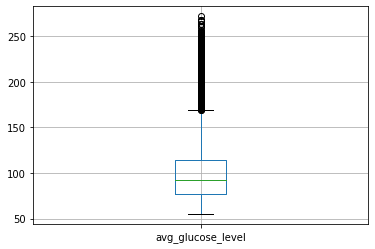

In [29]:
df_ml.boxplot(column = 'avg_glucose_level');

Many outliers in the 'avg_glucose_level' column.

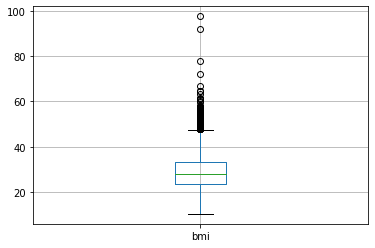

In [30]:
df_ml.boxplot(column = 'bmi',);

Several outliers in the 'bmi' values.

The following function was adapted from https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/

In [31]:
#create a function to find outliers using IQR

def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1
   print(f'The first quartile is: {q1:.2f}.')
   print(f'The third quartile is: {q3:.2f}.')
   print(f'The upper fence is {(q3+1.5*IQR):.02f}.')
   print(f'The lower fence is {(q1 - 1.5*IQR):.02f}.')

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

### Outlier information for 'bmi' column.

In [32]:
outliers = find_outliers_IQR(df_ml['bmi'])

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

The first quartile is: 23.50.
The third quartile is: 33.10.
The upper fence is 47.50.
The lower fence is 9.10.
number of outliers: 110
max outlier value: 97.6
min outlier value: 47.6


### Outlier information for 'avg_glucose_level' column.

In [33]:
outliers = find_outliers_IQR(df_ml['avg_glucose_level'])

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

The first quartile is: 77.24.
The third quartile is: 114.09.
The upper fence is 169.37.
The lower fence is 21.96.
number of outliers: 627
max outlier value: 271.74
min outlier value: 169.43


### Outlier information for 'age' column.

In [34]:
outliers = find_outliers_IQR(df_ml['age'])

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

The first quartile is: 25.00.
The third quartile is: 61.00.
The upper fence is 115.00.
The lower fence is -29.00.
number of outliers: 0
max outlier value: nan
min outlier value: nan


## **Project 2 - Part 3 Tasks:**

### **1. Identify any moderate or strong correlations between your target and your features and/or between one feature and another using a correlation heatmap.**

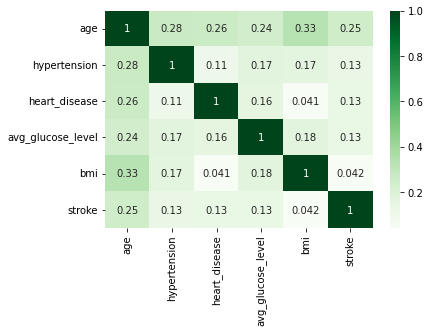

In [35]:
# create the correlations
corr = df_ml.corr()

# plot the correlations created above in a heatmap
sns.heatmap(corr, cmap = 'Greens', annot = True);


There are no moderate or strong correlations between the target 'stroke' with any other feature.  The largest correlation value including the 'stroke' target is the correlation of 0.25 with 'age'.  However, the largest correlation value between any two features is 0.33 between the 'age' and 'bmi' features.  This is still not a moderate or strong correlation.

### **2. Create multivariate (multiple variables) exploratory visualizations to further understand your data and search for trends.**

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


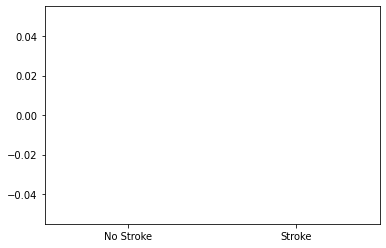

In [36]:
## create a side by side boxplot of 'bmi' across 'stroke'
no_stroke_label = df_ml.loc[df['stroke']== 0, 'bmi'].values
stroke_label = df_ml.loc[df['stroke']== 1, 'bmi'].values
plt.boxplot([no_stroke_label, stroke_label], labels = ['No Stroke', 'Stroke']);



The distribution of 'bmi' of individuals with stroke is less spread out than the distribution of 'bmi' of individuals without stroke.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


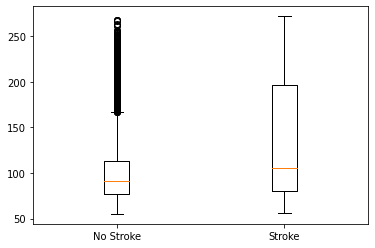

In [37]:
## create a side by side boxplot of 'avg_glucose_level' across 'stroke'
no_stroke_label = df_ml.loc[df['stroke']== 0, 'avg_glucose_level'].values
stroke_label = df_ml.loc[df['stroke']== 1, 'avg_glucose_level'].values
plt.boxplot([no_stroke_label, stroke_label], labels = ['No Stroke', 'Stroke']);

The distribution of 'avg_glucose_level' of individuals with stroke is more spread out than the distribution of 'avg_glucose_level' of individuals without stroke.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


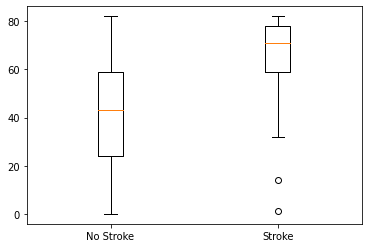

In [38]:
## create a side by side boxplot of 'age' across 'stroke'
no_stroke_label = df_ml.loc[df['stroke']== 0, 'age'].values
stroke_label = df_ml.loc[df['stroke']== 1, 'age'].values
plt.boxplot([no_stroke_label, stroke_label], labels = ['No Stroke', 'Stroke']);

The distribution of 'age' of individuals with stroke is less spread out than the distribution of 'age' of individuals without stroke.  Overall, the values of the 'age' distribution are higher for those with stroke.

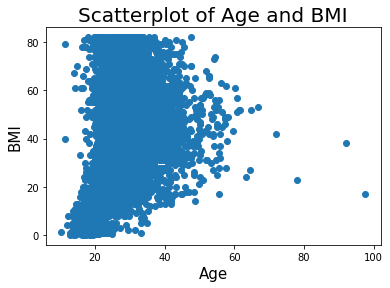

In [39]:
## producing a scatterplot of 'age'' with 'bmi'
age_corr = df_ml['age'].values
bmi_corr = df_ml['bmi'].values
# stroke_corr = df['stroke'].values

plt.scatter(bmi_corr, age_corr)

## titles and labels
plt.title('Scatterplot of Age and BMI', fontsize = 20)
plt.ylabel('BMI', fontsize = 15)
plt.xlabel('Age', fontsize = 15);


The correlation of 'age' and 'bmi' from the heatpmap earlier was 0.33.  This scatterplot supports that there does not appear to be a linear association between these two features. 

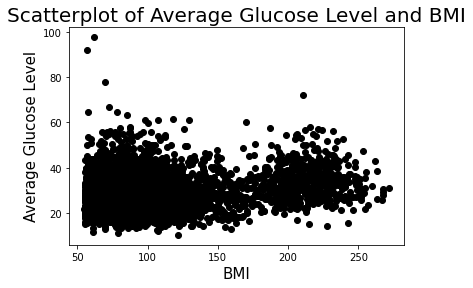

In [40]:
## producing a scatterplot of 'ave_glucose_level'' with 'bmi'
avg_corr = df['avg_glucose_level'].values
bmi_corr = df['bmi'].values

plt.scatter(avg_corr, bmi_corr, c = 'k')

## titles and labels
plt.title('Scatterplot of Average Glucose Level and BMI', fontsize = 20)
plt.ylabel('Average Glucose Level', fontsize = 15)
plt.xlabel('BMI', fontsize = 15);


The correlation of 'average glucose' and 'bmi' from the heatpmap earlier was 0.17.  This scatterplot supports that there does not appear to be a linear association between these two features.

The following is a grouped bar chart exploring the 'hypertension' and 'stroke' features together.  There is an increased percentage of stroke incidence with the presence of hypertension.

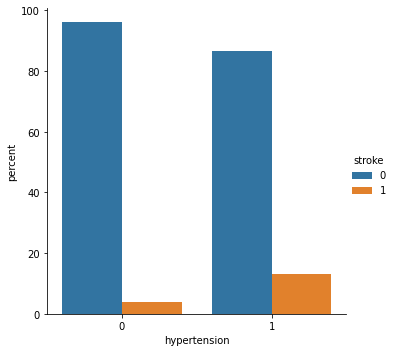

In [41]:

x,y = 'hypertension', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

The following is a grouped bar chart exploring the 'heart disease' and 'stroke' features together.  There is an increased percentage of stroke incidence with the presence of heart disease.

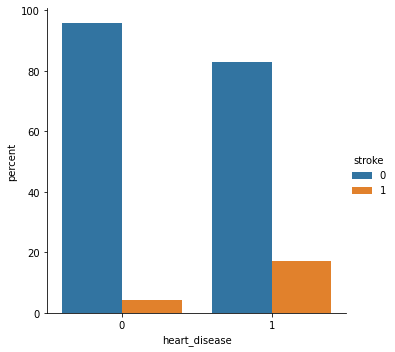

In [42]:
x,y = 'heart_disease', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

The following is a grouped bar chart exploring the 'ever married' and 'stroke' features together.  There is an increased percentage of stroke incidence with the presence of marriage.

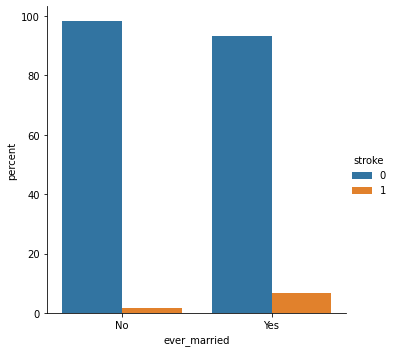

In [43]:
x,y = 'ever_married', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

The following is a grouped bar chart exploring the 'work_type' and 'stroke' features together.  There is an increased percentage of stroke incidence for those self-employed over other types of work.

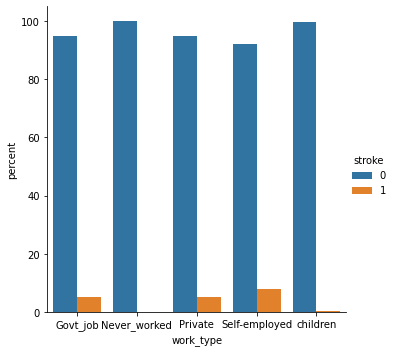

In [44]:
x,y = 'work_type', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

The following is a grouped bar chart exploring the 'smoking_status' and 'stroke' features together.  There is an increased percentage of stroke incidence for those who formerly smoked over other categories.

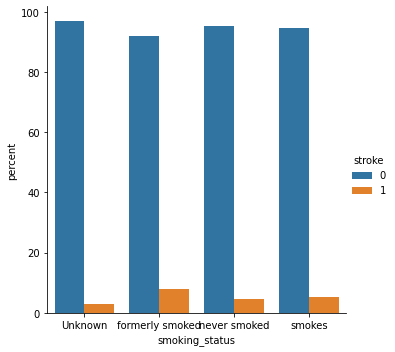

In [45]:
x,y = 'smoking_status', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

The following is a grouped bar chart exploring the 'gender' and 'stroke' features together.  The stroke incidence is comparable for male and female genders.

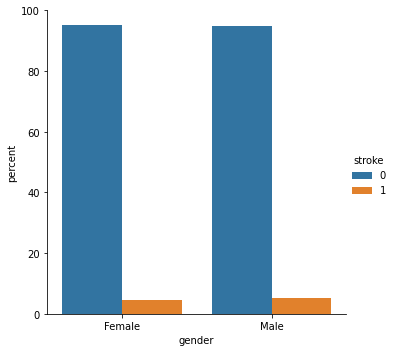

In [46]:
x,y = 'gender', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

## **Explanatory Visuals**

### **3.  Choose two visualizations from your analysis that demonstrate key trends you found that will be of interest to a stakeholder. These visuals should be reporting quality with titles, labels, and a short explanation of the trend. Be sure to explain in a text cell the finding associated with each visual. Both of these visualizations should be easily understood by a non-technical audience (Neither should be histograms, boxplots, or correlation plots).**

In [47]:
# create a copy of the data frame for explanatory visuals
df_exp = df_ml.copy()
df_exp.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The next three cells are used to relabel the legend and x-axis.

In [48]:
df_exp['stroke'] = df_exp['stroke'].map({0: 'no stroke', 1: 'stroke'})

In [49]:
df_exp['hypertension'] = df_exp['hypertension'].map({0: 'no hypertension', 1: 'hypertension present'})

In [50]:
df_exp['heart_disease'] = df_exp['heart_disease'].map({0: 'no heart disease', 1: 'heart disease present'})

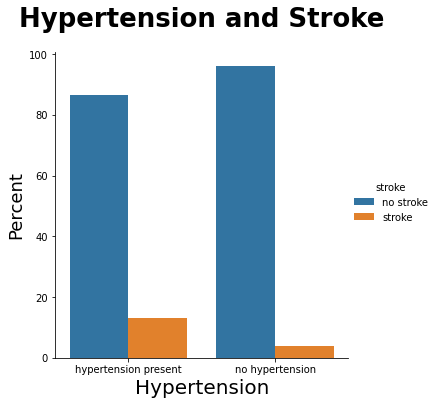

In [51]:
x,y = 'hypertension', 'stroke'


(df_exp
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

## titles and labels
plt.title('Hypertension and Stroke', fontsize = 26, fontweight='semibold', pad = 25)
plt.ylabel('Percent', fontsize = 18)
plt.xlabel('Hypertension', fontsize = 20);

The grouped bar chart above is a visualization of the association between the presence of hypertension and the presence of stroke in individuals.  There is more than double the incidence of stroke for individuals when hypertension was present.

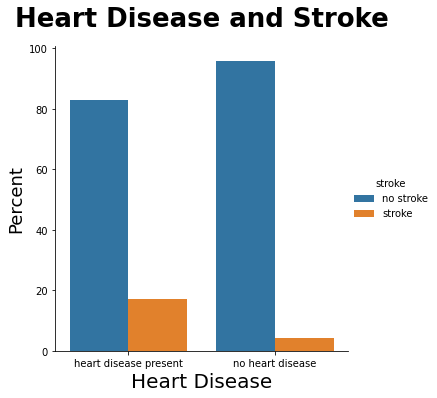

In [52]:
x,y = 'heart_disease', 'stroke'


(df_exp
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))



## titles and labels
plt.title('Heart Disease and Stroke', fontsize = 26, fontweight='semibold', pad = 20)
plt.ylabel('Percent', fontsize = 18)
plt.xlabel('Heart Disease', fontsize = 20);

The grouped bar chart above is a visualization of the association between the presence of heart disease and the presence of stroke in individuals.  There is more than double the incidence of stroke for individuals when heart disease was present.

The code for these two explanatory visualizations was adapted from https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group

## **Project 2 - Part 4 Tasks: Model Development Phase**
- Ensure that you complete the appropriate pre-processing steps.
- Try multiple models and tune the hyperparameters of each model to optimize model performance (include all models and hyperparameters tested in addition to the final model).
- Perform PCA or another feature engineering technique on your dataset to see how this impacts your results. (Try multiple techniques depending on data!).
- Evaluate model performance with appropriate metrics for the model.
- Choose "production" model and justify this decision.

## **Models, Prediction and Analysis**

### ***Pre_Processing***

In [53]:
# perform the train/test split
X = df_ml.drop(columns = ['stroke'])
y = df_ml['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



In [54]:
# Create preprocessor to impute and scale numeric data, and one-hot encode categorical data

# numeric impute and scale
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
numeric_pipe = make_pipeline(mean_imputer, scaler)

#categorical one hot encode
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

#column selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# categorical and numeric tuples
cat_tuple = (ohe, cat_selector)
num_tuple = (numeric_pipe, num_selector)

# preprocessor
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')



In [55]:
# fit the preprocessor on the X_train data
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d321a950>)])

In [56]:
# check the balancing of target 'stroke'
df_ml['stroke'].value_counts(normalize = True)

0    0.951262
1    0.048738
Name: stroke, dtype: float64

In [57]:
# check the balance of test data (baseline model)
y_test.value_counts(normalize = True)

0    0.937402
1    0.062598
Name: stroke, dtype: float64

### ***Models and Optimization***

In [58]:
## Evaluation function
def eval_classification(model,X_train,X_test,y_train,y_test):
    """Uses model.score to display the accuracy scores for training and test splits"""
    print(f"Model Training Accuracy: {model.score(X_train, y_train):.4f}")
    print(f"Model Test Accuracy: {model.score(X_test, y_test):.4f}")

#### **Decision Tree**

In [59]:
# Create a model pipeline with the preprocessor and a Decision Tree Classifier model
dec_tree = DecisionTreeClassifier()
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
dec_tree_pipe.fit(X_train, y_train) 


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d32

In [60]:
eval_classification(dec_tree_pipe, X_train, X_test, y_train, y_test)

Model Training Accuracy: 1.0000
Model Test Accuracy: 0.9085


In [182]:
dt_test_preds = dec_tree_pipe.predict(X_test)
print(classification_report(y_test, dt_test_preds))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1198
           1       0.23      0.20      0.21        80

    accuracy                           0.91      1278
   macro avg       0.59      0.58      0.58      1278
weighted avg       0.90      0.91      0.91      1278



##### **Decision Tree Tuning**

In [62]:
# preprocessor
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')

In [63]:
# fit the preprocessor on the X_train data
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d321a950>)])

In [64]:
# instantiate a decision tree model and create a parameter grid dictionary
dt_model = DecisionTreeClassifier(random_state=42)

dt_model_pipe = make_pipeline(preprocessor, dt_model)

# dt_model_pipe.get_params()


In [158]:
# create a decision tree parameter grid
dt_param_grid = {'decisiontreeclassifier__max_depth':(1, 5),
                  'decisiontreeclassifier__min_samples_leaf': (1, 5),
                  'decisiontreeclassifier__min_samples_split': (2, 200),
                  'decisiontreeclassifier__class_weight': [None, 'balanced']}

In [159]:
# instantiate the  Decision Tree GridSearchCV Class
dt_grid_search = GridSearchCV(dt_model_pipe, dt_param_grid)

In [160]:
# fit Decision Tree GridSeachCv on training data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [161]:
# examine best parameters for Decision Tree found by search
dt_grid_search.best_params_

{'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2}

In [162]:
# instantiate best Decision Tree using best estimator
dt_best_model = dt_grid_search.best_estimator_

# fit best Decision Tree model
dt_best_model.fit(X_train, y_train)

# evaluate best Decision Tree model
dt_best_model.score(X_test, y_test)



0.9374021909233177

In [183]:
dt_best_test_preds = dt_best_model.predict(X_test)
print(classification_report(y_test, dt_best_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Bagged Tree**

In [71]:
# Create a model pipeline with the preprocessor and a Bagging Classifier model
bag_clf = BaggingClassifier(random_state=42)
bag_clf_pipe = make_pipeline(preprocessor, bag_clf)
bag_clf_pipe.fit(X_train, y_train) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d32

In [72]:
eval_classification(bag_clf_pipe, X_train, X_test, y_train, y_test)

Model Training Accuracy: 0.9927
Model Test Accuracy: 0.9351


In [184]:
bt_test_preds = bag_clf_pipe.predict(X_test)
print(classification_report(y_test, bt_test_preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1198
           1       0.38      0.06      0.11        80

    accuracy                           0.94      1278
   macro avg       0.66      0.53      0.54      1278
weighted avg       0.91      0.94      0.91      1278



##### **Bagged Tree Tuning**

In [73]:
# instantiate a bagging tree model and create a parameter grid dictionary
bt_model = BaggingClassifier(random_state=42)

bt_model_pipe = make_pipeline(preprocessor, bt_model)

bt_model_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d321a950>)])),
  ('baggingclassifier', BaggingClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='p

In [74]:
# create a bagging tree parameter grid dictionary
bt_param_grid = {'baggingclassifier__max_features':(1, 10),
                  'baggingclassifier__max_samples': (1, 10),
                  'baggingclassifier__n_estimators': (2, 50)}

In [75]:
# instantiate bagging tree GridSearchCV Class
bt_grid_search = GridSearchCV(bt_model_pipe, bt_param_grid)

In [76]:
# fit bagging tree GridSeachCv on training data
bt_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [77]:
# examine bagging tree best parameters found by search
bt_grid_search.best_params_

{'baggingclassifier__max_features': 1,
 'baggingclassifier__max_samples': 1,
 'baggingclassifier__n_estimators': 2}

In [78]:
# instantiate best bagging Tree using best estimator
bt_best_model = dt_grid_search.best_estimator_

# fit best bagging tree 
bt_best_model.fit(X_train, y_train)

# score best bagging tree
bt_best_model.score(X_test, y_test)

0.9374021909233177

In [185]:
bt_best_test_preds = bt_best_model.predict(X_test)
print(classification_report(y_test, bt_best_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### **Bagged Tree with PCA**

In [ ]:
# Create a transformer pipeline 
# transformer = make_pipeline(scaler, PCA(n_components=.95))

#### **Random Forest**

In [79]:
# Create a model pipeline with the preprocessor and a Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf_pipe = make_pipeline(preprocessor, rf_clf)
rf_clf_pipe.fit(X_train, y_train) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d32

In [80]:
eval_classification(rf_clf_pipe, X_train, X_test, y_train, y_test)

Model Training Accuracy: 1.0000
Model Test Accuracy: 0.9374


In [187]:
rf_test_preds = rf_clf_pipe.predict(X_test)
print(classification_report(y_test, rf_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Random Forest Tuning**

In [81]:
# instantiate a random forest model and get model parameters
rf_model = RandomForestClassifier(random_state=42)

rf_model_pipe = make_pipeline(preprocessor, rf_model)

rf_model_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d321a950>)])),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(re

In [82]:
# create random forest parameter grid dictionary
rf_param_grid = {'randomforestclassifier__max_depth':(1, 20),
                  'randomforestclassifier__max_leaf_nodes': (1, 500),
                  'randomforestclassifier__n_estimators': (2, 40)}

In [83]:
# instantiate random forest GridSearchCV Class
rf_grid_search = GridSearchCV(rf_model_pipe, rf_param_grid)


In [84]:
# fit random forest GridSeachCv on training data
rf_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packag

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [85]:
# examine random forest best parameters found by search
rf_grid_search.best_params_

{'randomforestclassifier__max_depth': 1,
 'randomforestclassifier__max_leaf_nodes': 500,
 'randomforestclassifier__n_estimators': 2}

In [86]:
# instantiate best bagging Tree using best estimator
rf_best_model = rf_grid_search.best_estimator_

# fit best random forest
rf_best_model.fit(X_train, y_train)

# score best random forest
rf_best_model.score(X_test, y_test)



0.9374021909233177

In [188]:
rf_best_test_preds = rf_best_model.predict(X_test)
print(classification_report(y_test, rf_best_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **KNN**

In [88]:
# Create a model pipeline with the preprocessor and a KNN model
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train) 


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d32

In [89]:
eval_classification(knn_pipe, X_train, X_test, y_train, y_test)

Model Training Accuracy: 0.9575
Model Test Accuracy: 0.9351


In [180]:
knn_test_preds = knn_pipe.predict(X_test)
print(classification_report(y_test, knn_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



##### **KNN Tuning**

In [90]:
# instantiate a knn model and create a parameter grid dictionary
knn_model = KNeighborsClassifier()

knn_model_pipe = make_pipeline(preprocessor, knn_model)

knn_model_pipe.get_params()


{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d321a950>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthroug

In [91]:
knn_param_grid = {'kneighborsclassifier__leaf_size':(1, 50),
                  'kneighborsclassifier__n_neighbors': (1, 50),
                  'kneighborsclassifier__p': (2, 50)}

In [92]:
# instantiate knn GridSearchCV Class
knn_grid_search = GridSearchCV(knn_model_pipe, knn_param_grid)

In [93]:
# fit knn GridSeachCv on training data
knn_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [94]:
# examine knn best parameters found by search
knn_grid_search.best_params_


{'kneighborsclassifier__leaf_size': 1,
 'kneighborsclassifier__n_neighbors': 50,
 'kneighborsclassifier__p': 2}

In [95]:

knn_best_model = knn_grid_search.best_estimator_

knn_best_model.fit(X_train, y_train)

knn_best_model.score(X_test, y_test)



0.9374021909233177

In [181]:
knn_best_test_preds = knn_best_model.predict(X_test)
print(classification_report(y_test, knn_best_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### **KNN with PCA**

In [96]:
# Create a transformer pipeline 
transformer = make_pipeline(preprocessor, PCA(n_components=.95))

In [101]:
# instantiate the KNN model with .95 PCA level
knn_95 = KNeighborsClassifier(n_neighbors = 10, p = 2, leaf_size = 1)

# create and fit a pipeline with the transformer including the PCA and the model 
knn_pipe_95 = make_pipeline(transformer, knn_95)
knn_pipe_95.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                

In [102]:
eval_classification(knn_pipe_95, X_train, X_test, y_train, y_test)

Model Training Accuracy: 0.9556
Model Test Accuracy: 0.9374


#### **Logistic Regression**

In [103]:
# Create a model pipeline with the preprocessor and a Logistic Regression model
log_reg = LogisticRegression()
log_pipe = make_pipeline(preprocessor, log_reg)
log_pipe.fit(X_train, y_train) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d32

In [104]:
eval_classification(log_pipe, X_train, X_test, y_train, y_test)

Model Training Accuracy: 0.9559
Model Test Accuracy: 0.9382


In [190]:
lr_test_preds = log_pipe.predict(X_test)
print(classification_report(y_test, lr_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.50      1278
weighted avg       0.94      0.94      0.91      1278



**Logistic Regression Tuning**

In [163]:
# instantiate logistic regression model and create a parameter grid dictionary
lr_model = LogisticRegression(random_state=42)

lr_model_pipe = make_pipeline(preprocessor, lr_model)

lr_model_pipe.get_params()


{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d321a950>)])),
  ('logisticregression', LogisticRegression(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder=

In [170]:
lr_param_grid = {'logisticregression__class_weight': [None, 'balanced'],
                  'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'logisticregression__max_iter': (50, 2000),
                  'logisticregression__solver': ['liblinear'],
                  'logisticregression__penalty':[None, 'l1', 'l2']}


In [171]:
# instantiate logistic regression GridSearchCV Class
lr_grid_search = GridSearchCV(lr_model_pipe, lr_param_grid)


In [172]:
# fit GridSeachCv on training data
lr_grid_search.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
160 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score=

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [173]:
# examine logistic regression best parameters found by search
lr_grid_search.best_params_

{'logisticregression__C': 0.0001,
 'logisticregression__class_weight': None,
 'logisticregression__max_iter': 50,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [174]:
lr_best_model = lr_grid_search.best_estimator_

lr_best_model.fit(X_train, y_train)

lr_best_model.score(X_test, y_test)


0.9374021909233177

In [191]:
lr_best_test_preds = lr_best_model.predict(X_test)
print(classification_report(y_test, lr_best_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Gradient Booster**

In [111]:
# Create a model pipeline with the preprocessor and a  gradient boosting classifier model
gbc = GradientBoostingClassifier()
gbc_pipe = make_pipeline(preprocessor, gbc)
gbc_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d32

In [112]:
eval_classification(gbc_pipe, X_train, X_test, y_train, y_test)

Model Training Accuracy: 0.9642
Model Test Accuracy: 0.9374


In [192]:
gbc_test_preds = gbc_pipe.predict(X_test)
print(classification_report(y_test, gbc_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.50      0.05      0.09        80

    accuracy                           0.94      1278
   macro avg       0.72      0.52      0.53      1278
weighted avg       0.91      0.94      0.91      1278



##### **Gradient Booster Tuning**

In [113]:
# instantiate gradient booster model and create a parameter grid dictionary
gbc_model = GradientBoostingClassifier()

gbc_model_pipe = make_pipeline(preprocessor, gbc_model)

gbc_model_pipe.get_params()



{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d321a950>)])),
  ('gradientboostingclassifier', GradientBoostingClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder

In [114]:
gbc_param_grid = {'gradientboostingclassifier__max_depth':(1, 10),
                  'gradientboostingclassifier__min_samples_leaf': (1, 10),
                  'gradientboostingclassifier__min_samples_split': (2, 10),
                  'gradientboostingclassifier__n_estimators': (2, 10)}

In [115]:
# instantiate gradient boosting GridSearchCV Class
gbc_grid_search = GridSearchCV(gbc_model_pipe, gbc_param_grid)

In [116]:
# fit gradient boosting GridSeachCv on training data
gbc_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [117]:
# examine gradient boosting best parameters found by search
gbc_grid_search.best_params_


{'gradientboostingclassifier__max_depth': 1,
 'gradientboostingclassifier__min_samples_leaf': 1,
 'gradientboostingclassifier__min_samples_split': 2,
 'gradientboostingclassifier__n_estimators': 2}

In [118]:

gbc_best_model = gbc_grid_search.best_estimator_

gbc_best_model.fit(X_train, y_train)

gbc_best_model.score(X_test, y_test)

0.9374021909233177

In [193]:
gbc_best_test_preds = gbc_best_model.predict(X_test)
print(classification_report(y_test, gbc_best_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **LightGBM**

In [119]:
# Create a model pipeline with the preprocessor and a Light GBM classifier model
lgbm = LGBMClassifier()
lgbm_pipe = make_pipeline(preprocessor, lgbm)
lgbm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d32

In [120]:
eval_classification(lgbm_pipe, X_train, X_test, y_train, y_test)

Model Training Accuracy: 0.9984
Model Test Accuracy: 0.9319


In [194]:
lgbm_test_preds = lgbm_pipe.predict(X_test)
print(classification_report(y_test, lgbm_test_preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1198
           1       0.29      0.06      0.10        80

    accuracy                           0.93      1278
   macro avg       0.62      0.53      0.53      1278
weighted avg       0.90      0.93      0.91      1278



##### **Light GBM Tuning**

In [142]:
# instantiate a light gbm model and create a parameter grid dictionary
lgbm_model = LGBMClassifier()

lgbm_model_pipe = make_pipeline(preprocessor, lgbm_model)

lgbm_model_pipe.fit(X_train, y_train)

lgbm_model_pipe.get_params()


{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d321a950>)])),
  ('lgbmclassifier', LGBMClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
        

In [143]:
lgbm_param_grid = {'lgbmclassifier__max_depth':(1, 30),
                  'lgbmclassifier__num_leaves': (1, 50),
                  'lgbmclassifier__n_estimators': (2, 200)}


In [144]:
# instantiate light gbm GridSearchCV Class
lgbm_grid_search = GridSearchCV(lgbm_model_pipe, lgbm_param_grid)

In [145]:
# fit light gbm GridSeachCv on training data
lgbm_grid_search.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1001, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/usr/local/lib/python3.7/dist-packages/lightgb

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [146]:
# examine light gbm best parameters found by search
lgbm_grid_search.best_params_


{'lgbmclassifier__max_depth': 1,
 'lgbmclassifier__n_estimators': 2,
 'lgbmclassifier__num_leaves': 50}

In [147]:

lgbm_best_model = lgbm_grid_search.best_estimator_

lgbm_best_model.fit(X_train, y_train)

lgbm_best_model.score(X_test, y_test)


0.9374021909233177

In [196]:
lgbm_best_test_preds = lgbm_best_model.predict(X_test)
print(classification_report(y_test, lgbm_best_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### **Light GBM with PCA**

In [127]:
# Create a transformer pipeline 
transformer = make_pipeline(preprocessor, PCA(n_components=4))

In [128]:
# instantiate the KNN model with .n = 4 PCA level
lgbm_4 = LGBMClassifier()

# create and fit a pipeline with the transformer including the PCA and the model 
lgbm_pipe_4 = make_pipeline(transformer, lgbm_4)
lgbm_pipe_4.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                

In [129]:
eval_classification(lgbm_pipe_4, X_train, X_test, y_train, y_test)

Model Training Accuracy: 0.9906
Model Test Accuracy: 0.9358


#### **XGBoost**

In [130]:
# Create a model pipeline with the preprocessor and a  XG Boost classifier model
xgb = XGBClassifier()
xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d32

In [131]:
eval_classification(xgb_pipe, X_train, X_test, y_train, y_test)

Model Training Accuracy: 0.9564
Model Test Accuracy: 0.9374


In [197]:
xgb_test_preds = xgb_pipe.predict(X_test)
print(classification_report(y_test, xgb_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**XGB TUNING**

In [132]:
# instantiate XGB model and create a parameter grid dictionary
xgb_model = XGBClassifier()

xgb_model_pipe = make_pipeline(preprocessor, xgb_model)

xgb_model_pipe.get_params()


{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d321a950>)])),
  ('xgbclassifier', XGBClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
          

In [133]:
xgb_param_grid = {'xgbclassifier__learning_rate':[0.1, 0.001, 0.0001, 1, 10],
                  'xgbclassifier__n_estimators': (10, 500),
                  'xgbclassifier__colsample_bynode': (1, 10)}


In [134]:
# instantiate the GridSearchCV Class
xgb_grid_search = GridSearchCV(xgb_model_pipe, xgb_param_grid)


In [135]:
# fit xgb GridSeachCv on training data
xgb_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/train

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f73d04544d0>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [136]:
# examine xgb best parameters found by search
xgb_grid_search.best_params_

{'xgbclassifier__colsample_bynode': 1,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__n_estimators': 10}

In [137]:

xgb_best_model = dt_grid_search.best_estimator_

xgb_best_model.fit(X_train, y_train)

xgb_best_model.score(X_test, y_test)


0.9374021909233177

In [198]:
xgb_best_test_preds = xgb_best_model.predict(X_test)
print(classification_report(y_test, xgb_best_test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### *Production Model*